In [97]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st

Gillespie SIR (Stochastic model)

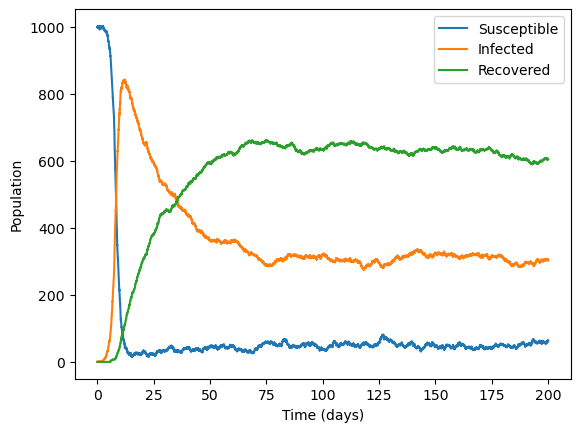

In [101]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # initialize arrays to store the variables
    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    R0_stoch = beta / (mu + gamma)

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Calculate rates for all events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # if rate_sum is zero, no more events possible
        if rate_sum <= 0:
            break  # No more events can happen, end the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)  # Append the new time

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # determine which event happens
        if rand < (cum_rate := cum_rate + birth_rate): # birth event
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # infection event
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # recovery event
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)

    return X, Y, Z, t, R0_stoch


N = 1000
tend = 200 # simulation time (200 days)
beta = 1
gamma = 1/30
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
seed = 42

Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

Deterministic SIR model

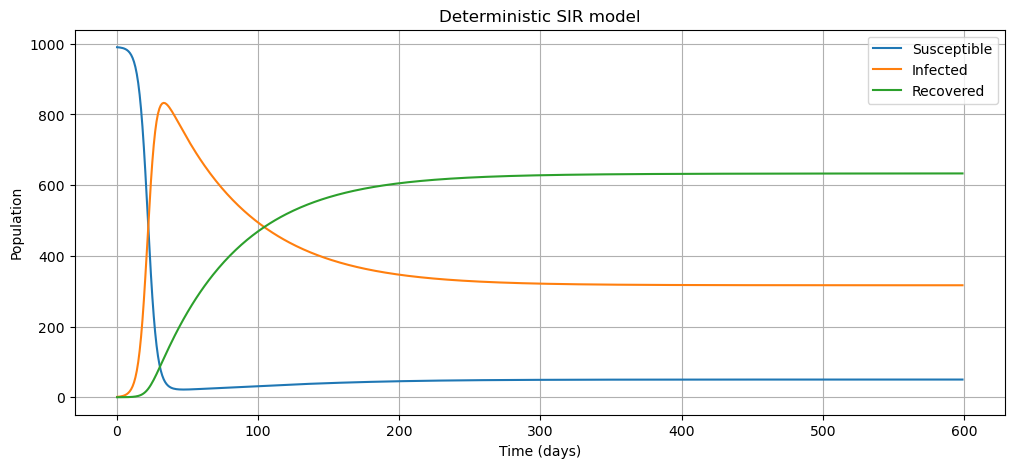

In [102]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

def SIR(val, t, beta, gamma, mu, N):
    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])


def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    R0_det = beta / (mu + gamma)

    time = np.linspace(start_t, end_t, points_t)
    init_val = [X0, Y0, Z0]
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu, N))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time, R0_det


Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.figure(figsize=(12,5))
plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()
# plt.savefig('FittingSIR.png', dpi=300)
plt.show()


Plotting deterministic and stochastic SIR

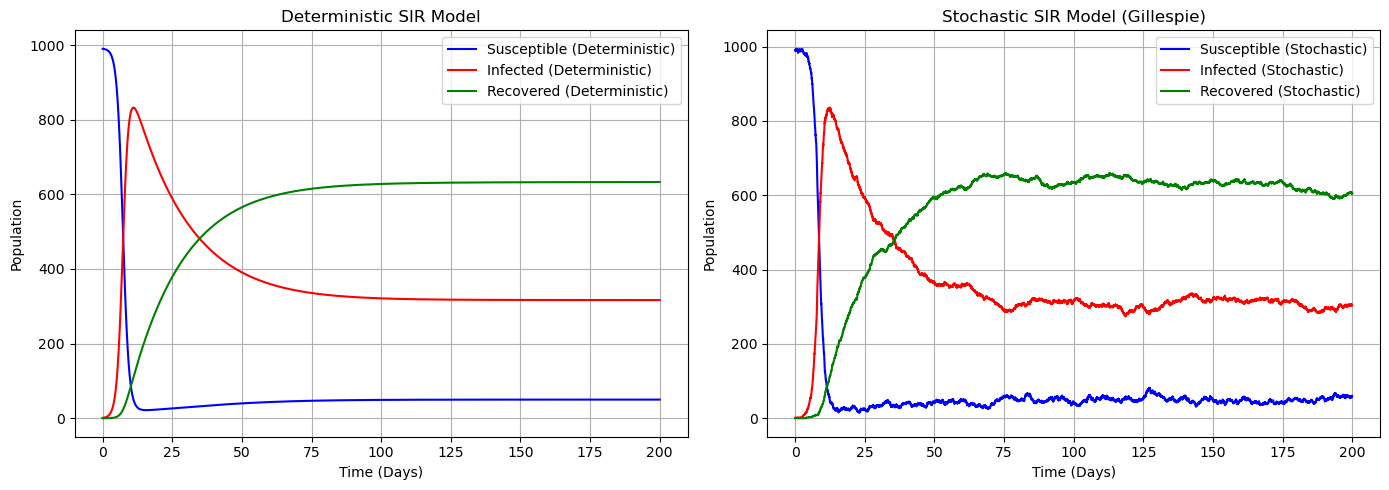

In [103]:
# solve the deterministic model
Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
# solve the stochastic model using the Gillespie algorithm
Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the deterministic model on the first subplot (ax1)
ax1.plot(time, Xd, label="Susceptible (Deterministic)", color='blue')
ax1.plot(time, Yd, label="Infected (Deterministic)", color='red')
ax1.plot(time, Zd, label="Recovered (Deterministic)", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

# Plot the stochastic model on the second subplot (ax2)
ax2.plot(t, Xs, label="Susceptible (Stochastic)", color='blue')
ax2.plot(t, Ys, label="Infected (Stochastic)", color='red')
ax2.plot(t, Zs, label="Recovered (Stochastic)", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Function to run multiple simulations of Gillespie's agorithm and return mean and variance of X, Y, Z across simulations

Number of simulations: 50
Final mean of Susceptibles: 142.87121439027328
Final variance of Susceptibles: 75564.21680862013
Final mean of Infected: 280.53527589860664
Final variance of Infected: 9042.127827824197


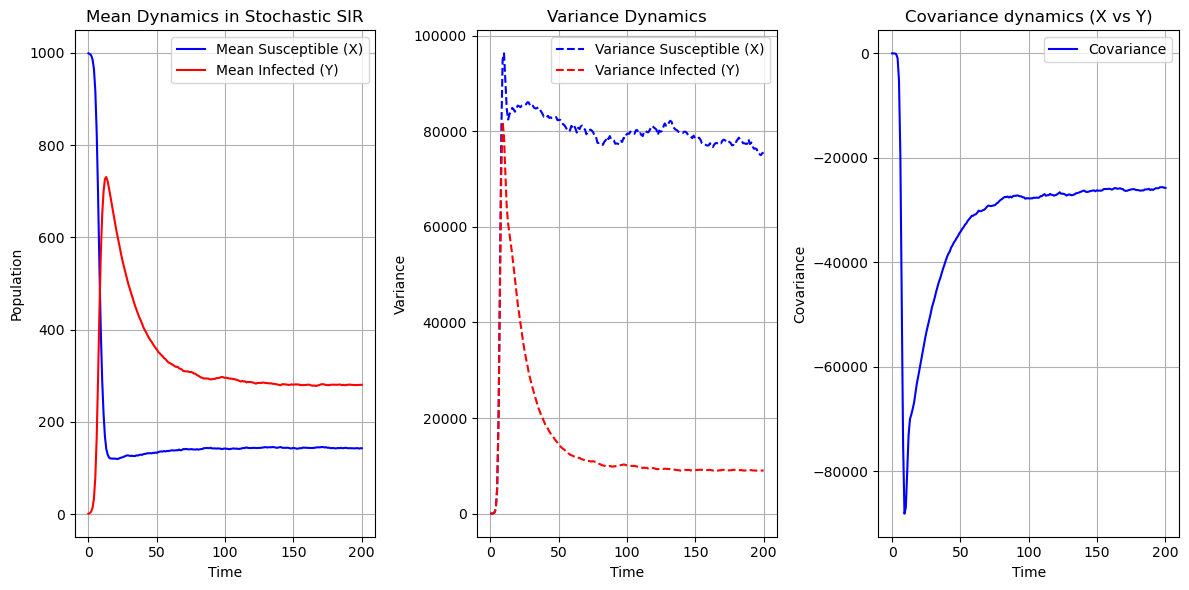

In [104]:
# Assuming gillespie_sir is defined elsewhere
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed):
    # will accumulate Xs, Ys, Zs across simulations
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []
    cov_array = np.zeros(tend)

    time_p = np.linspace(0, tend, 200) # 200 time points

    for i in range(sims):
        # Run the Gillespie simulation for the current iteration
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    # average population size of each compartment at each time point
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # variability of population sizes from the mean across different simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    return time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys

def covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend):

    cov_Xs_Ys = np.zeros(tend)

    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    
    return cov_Xs_Ys

def mean_det_inf(sims, X0, Y0, Z0, Yd, beta, gamma, mu, N, tend):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, 0, tend, 200)
    mean_Yd = np.mean(Yd, axis=0)      
    return mean_Yd

sims = 50
X0 = 999
Y0 = 1
Z0 = 0
beta = 1
gamma = 1/30
mu = 1/60
N = X0 + Y0 + Z0
tend = 200

# Run the stochastic simulations
time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend)

# Print the results
print(f"Number of simulations: {sims}")
print(f"Final mean of Susceptibles: {mean_Xs[-1]}")
print(f"Final variance of Susceptibles: {var_Xs[-1]}")
print(f"Final mean of Infected: {mean_Ys[-1]}")
print(f"Final variance of Infected: {var_Ys[-1]}")


# plotting the mean and the variance
fig, axes = plt.subplots(1, 3, figsize = (12,6))

# Plot Mean on the first subplot (axes[0])
axes[0].plot(time_p, mean_Xs, label='Mean Susceptible (X)', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected (Y)', color='red')
axes[0].set_title("Mean Dynamics in Stochastic SIR")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_p, var_Xs, label='Variance Susceptible (X)', color='blue', linestyle='--')
axes[1].plot(time_p, var_Ys, label='Variance Infected (Y)', color='red', linestyle='--')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Covariance', color='blue')
axes[2].set_title("Covariance dynamics (X vs Y)")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Covariance")
axes[2].legend()
axes[2].grid(True)

# Adjust spacing between the two plots
plt.tight_layout()


# Varying model parameters

In [105]:
# Fixed parameters
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 5

Varying N

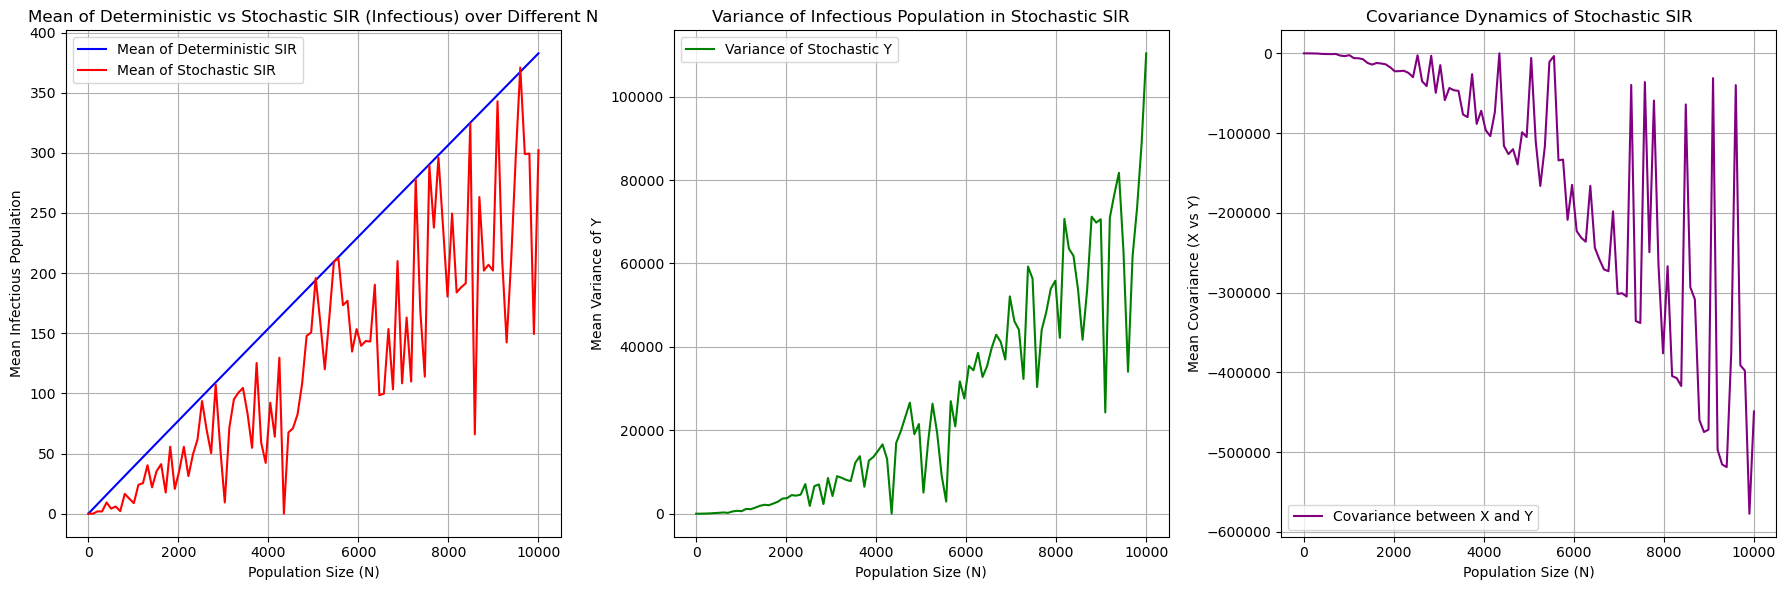

([0.08313502527073542,
  4.0202900966036585,
  7.964791430779069,
  11.896431621829421,
  15.81970315316864,
  19.736747114156795,
  23.648826301345572,
  27.55677622460824,
  31.461190793248814,
  35.362514343470906,
  39.261091837769,
  43.157199189057636,
  47.05106152263331,
  50.94286659173209,
  54.8327727992478,
  58.720916281835215,
  62.607415388674305,
  66.49237233898792,
  70.37587877376558,
  74.25801422963366,
  78.13885316013273,
  82.01845897004544,
  85.89689047527749,
  89.77420189690747,
  93.65044174253643,
  97.52565490231946,
  101.39988222733473,
  105.27316188866233,
  109.14552898945847,
  113.01701601217904,
  116.88765419673584,
  120.75747115237783,
  124.6264940784452,
  128.49474698894056,
  132.36225339824628,
  136.2290363712514,
  140.09511501674925,
  143.9605109372869,
  147.82524048035057,
  151.68932230767933,
  155.5527737316166,
  159.41560924237578,
  163.2778447025249,
  167.13949340715305,
  171.00057139324664,
  174.86108876777973,
  178.72106

In [106]:
# Different values of population
N_diff = np.linspace(2, 10000, 100)

def diff_params_N(N_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different population sizes
    for n in np.nditer(N_diff):
        X0 = int(n) - 1  # Initial susceptible population
        Y0 = 1            # Initial infected population
        Z0 = 0            # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, int(n), tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, int(n), beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append final mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the final mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the final mean for stochastic Y
        
        # Append final variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append final covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different N")
    axes[0].set_xlabel("Population Size (N)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(N_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over N
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Population Size (N)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(N_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over N
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Population Size (N)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

diff_params_N(N_diff, sims, beta, gamma, mu)

Varying Y0 (initial number of infectious individuals)

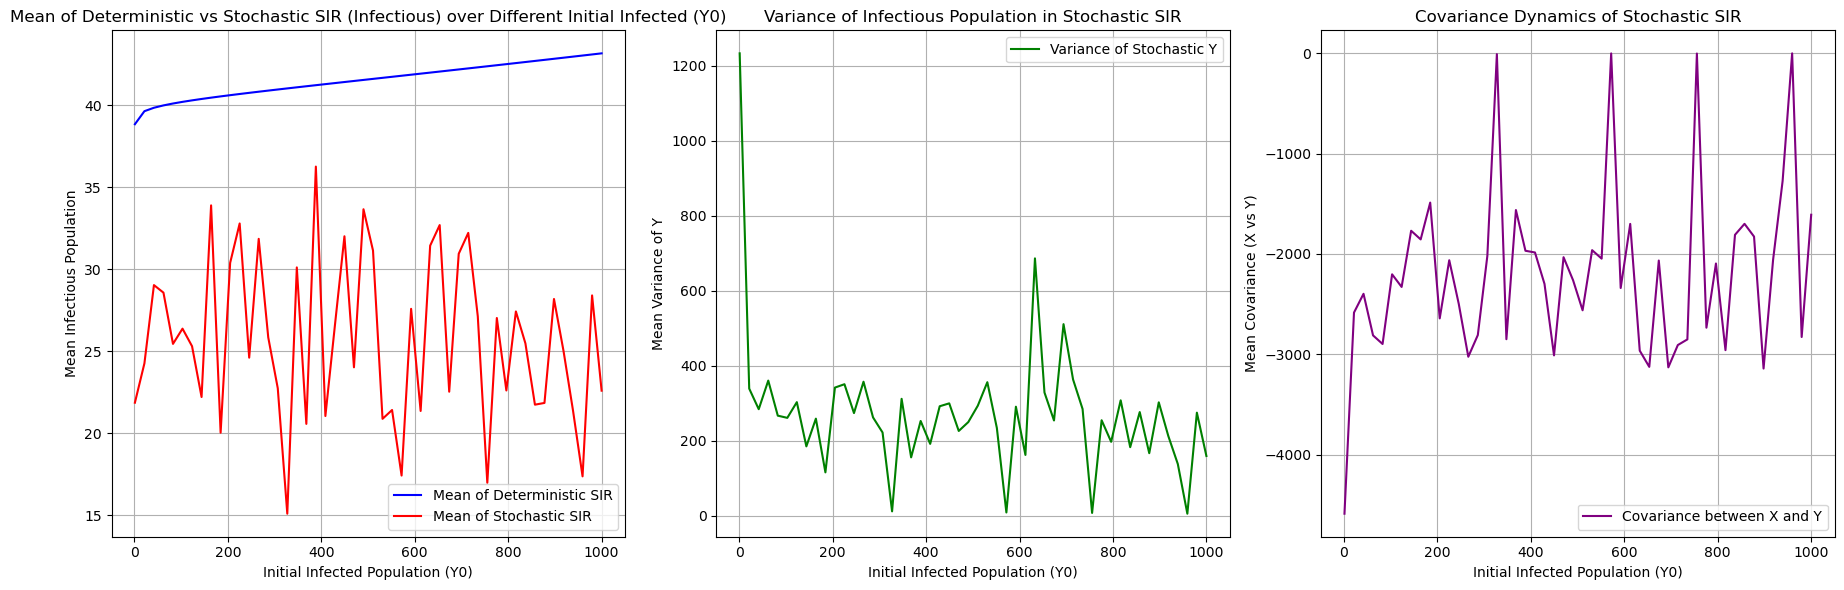

([38.836618732812255,
  39.63116133442313,
  39.84053162528243,
  39.98374290716619,
  40.09948752163034,
  40.200199370773625,
  40.291479750915926,
  40.37633660746935,
  40.456573876521034,
  40.53335889743301,
  40.607491661596576,
  40.67954370025737,
  40.74993791896634,
  40.81899629113971,
  40.886969517653334,
  40.95405606194825,
  41.02041676813486,
  41.08618273514102,
  41.151462625185076,
  41.21634738403902,
  41.280914240553976,
  41.34522805955743,
  41.40934512138925,
  41.4733139159554,
  41.53717566322648,
  41.60096757803633,
  41.664720862068336,
  41.728463804889195,
  41.79222062141197,
  41.856013484242915,
  41.9198612105267,
  41.98378041510839,
  42.04778649724189,
  42.111892277549714,
  42.1761101301428,
  42.240449950327175,
  42.30492102783117,
  42.36953181928078,
  42.434289379840955,
  42.49920004816255,
  42.56426967989324,
  42.629502665985555,
  42.69490426362577,
  42.76047762054066,
  42.82622620634265,
  42.892152866603794,
  42.95825998542328,


In [107]:
Y0_diff = np.linspace(1, 1000, 50)

def diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different initial infected populations Y0
    for y0 in Y0_diff:
        X0 = N - y0  # Initial susceptible population
        Y0 = y0      # Initial infected population
        Z0 = 0       # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(Y0_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(Y0_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Initial Infected (Y0)")
    axes[0].set_xlabel("Initial Infected Population (Y0)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(Y0_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over Y0
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Initial Infected Population (Y0)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(Y0_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over Y0
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Initial Infected Population (Y0)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu)


In [108]:
X0 = 999
Y0 = 1
Z0 = 0

Varying beta (transmission rate)

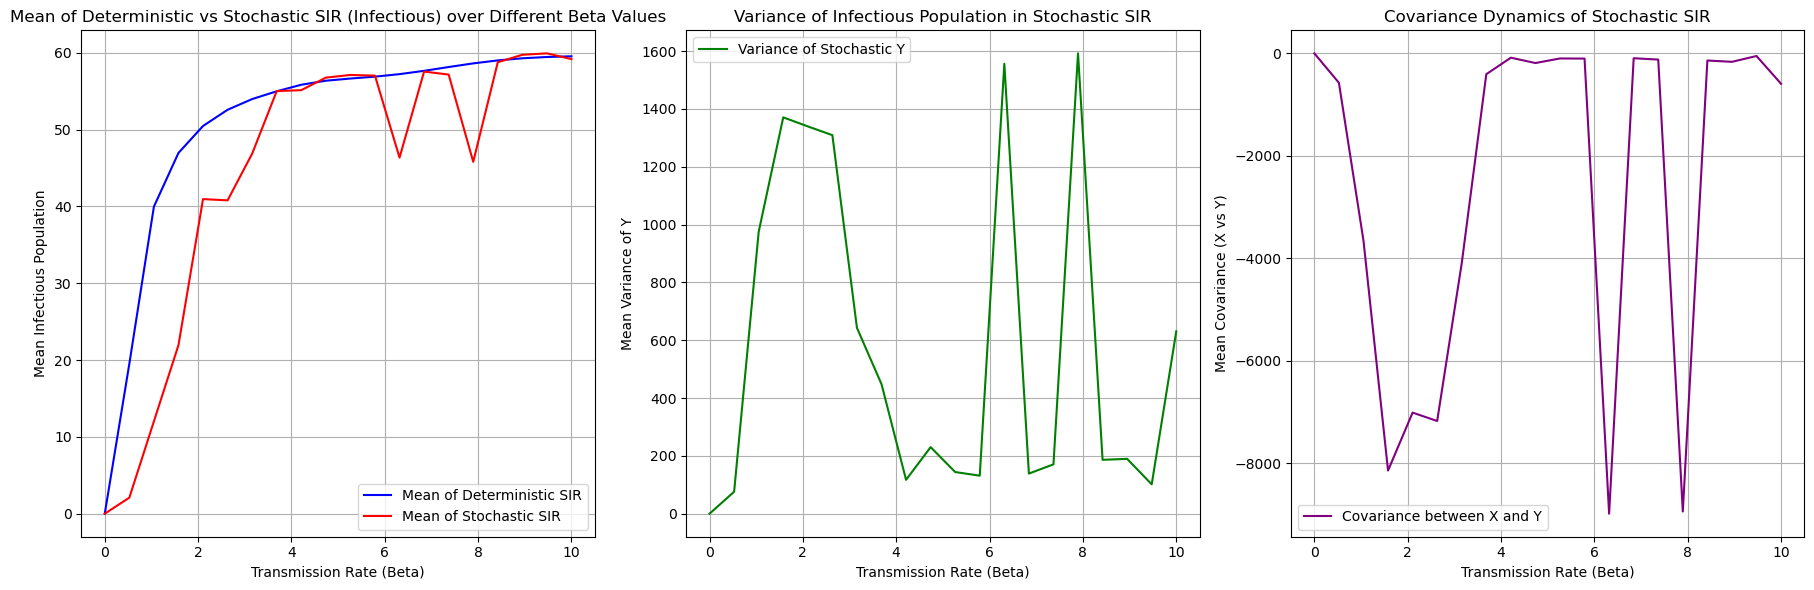

([0.016860548643746892,
  19.520508208678788,
  39.97622692482012,
  46.96913457965733,
  50.47783144706309,
  52.58854013625409,
  53.98002394788929,
  54.99573066330505,
  55.84435192080029,
  56.37011679313897,
  56.65369879794466,
  56.89831702866941,
  57.22524883226131,
  57.65831527768988,
  58.151007622038996,
  58.624472729987566,
  59.01247075557734,
  59.28772964427886,
  59.45796142755931,
  59.54744584981872],
 [0.021,
  2.1019375266850924,
  12.037672698708832,
  21.94882402252535,
  40.96174868082497,
  40.7980904639577,
  46.87571933817564,
  55.017191550115776,
  55.13966027696906,
  56.7707415143165,
  57.119710581674696,
  57.03053038830052,
  46.3618485682147,
  57.56133895554298,
  57.16777902187586,
  45.811388445160425,
  58.77213512009501,
  59.743367975611726,
  59.931119696427615,
  59.18184986961073],
 [0.009600000000000003,
  76.04060606556439,
  975.1134367357315,
  1370.891915367519,
  1339.5750766707297,
  1309.344886081878,
  642.7751309564566,
  448.173

In [109]:
beta_diff = np.linspace(0, 10, 20)

def diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different beta values
    for beta in beta_diff:
        
        # Run stochastic simulations for the current beta
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current beta
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(beta_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(beta_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Beta Values")
    axes[0].set_xlabel("Transmission Rate (Beta)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(beta_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over beta
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Transmission Rate (Beta)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(beta_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over beta
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Transmission Rate (Beta)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with fixed parameters and varying beta
diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0)

Varying gamma (rate of recovery)

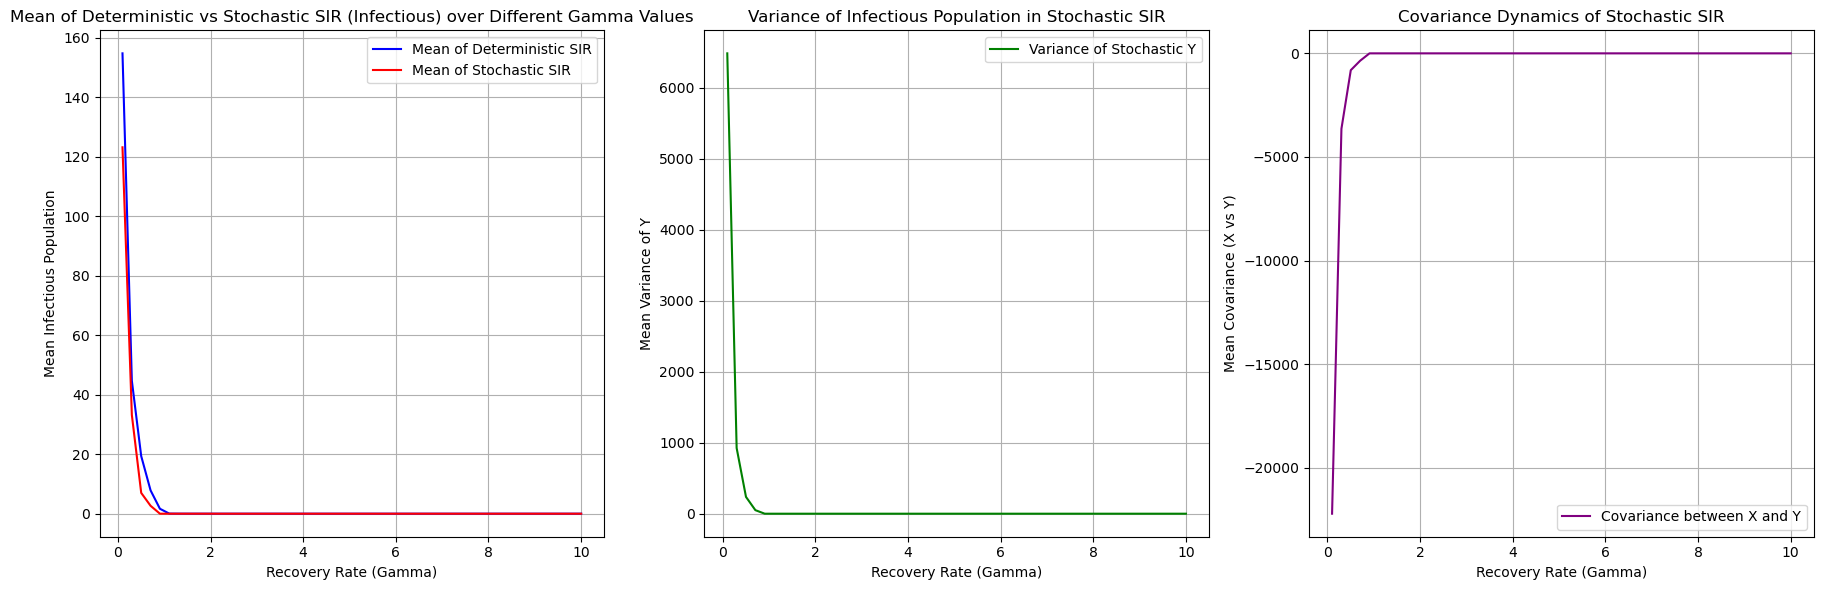

([154.7255745958489,
  44.686734625685496,
  19.364569199262338,
  7.848122371296584,
  1.6661492186177163,
  0.04049159581775233,
  0.01765460160916102,
  0.012058647847412311,
  0.009576699004100688,
  0.008198438444196815,
  0.007336341790788003,
  0.006756331753706305,
  0.006346718940601662,
  0.006047433613998005,
  0.005823280846178634,
  0.00565226807058128,
  0.005519947789048163,
  0.005416446581560497,
  0.005334797862907316,
  0.005269954472567259,
  0.005218183259241943,
  0.005176673016298879,
  0.005143277483391865,
  0.005116336196988131,
  0.005094553450962666,
  0.005076910920923747,
  0.005062600631969541,
  0.005050979634576705,
  0.005041533850793609,
  0.0050338499457606945,
  0.0050275950301386955,
  0.005022501624260018,
  0.005018351103800969,
  0.005014968775023795,
  0.005012211309462364,
  0.005009962857326228,
  0.005008129007041163,
  0.005006633344772768,
  0.005005412959812594,
  0.005004417484184893,
  0.005003605165252492,
  0.0050029422523062885,
  0.

In [113]:
gamma_diff = np.linspace(0.1, 10, 50)


def diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different gamma values
    for gamma in gamma_diff:

        # Run stochastic simulations for the current gamma
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current gamma
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(gamma_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(gamma_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Gamma Values")
    axes[0].set_xlabel("Recovery Rate (Gamma)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(gamma_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over gamma
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Recovery Rate (Gamma)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(gamma_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over gamma
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Recovery Rate (Gamma)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with fixed parameters and varying gamma
diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0)

Varying mu (birth rate)

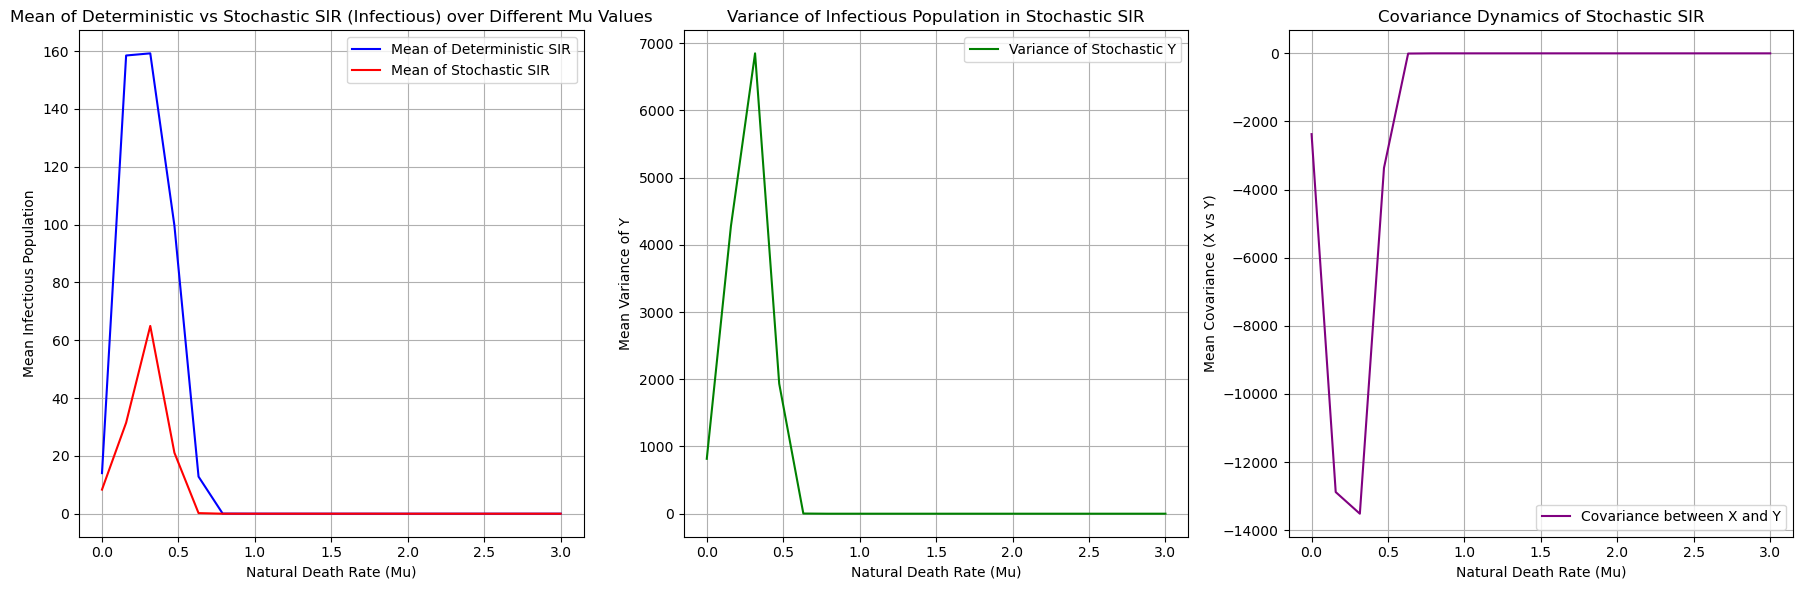

([14.039965321719858,
  158.4730676461835,
  159.2136354989264,
  99.67142228681723,
  12.82496698363051,
  0.042839003397808856,
  0.020301230494358183,
  0.014010796832400403,
  0.01108092060614814,
  0.009403054174886532,
  0.008327149575733956,
  0.007586458981495441,
  0.007051279005250761,
  0.006650934063187211,
  0.006343612034081993,
  0.006102985172529024,
  0.005911644740942563,
  0.005757617344575774,
  0.0056323972956140245,
  0.005529777870007505],
 [8.34080998148411,
  31.470437882318528,
  64.94670528014167,
  21.093914808031624,
  0.209,
  0.006999999999999999,
  0.006,
  0.005,
  0.011000000000000001,
  0.006,
  0.006999999999999999,
  0.012999999999999998,
  0.005,
  0.005,
  0.005,
  0.008,
  0.005,
  0.005,
  0.006,
  0.005],
 [816.963063961302,
  4277.798272524127,
  6848.648272447568,
  1934.9594850412932,
  2.4400000000000004,
  0.0012000000000000003,
  0.0008000000000000003,
  0.0,
  0.0068000000000000005,
  0.0008000000000000001,
  0.0012000000000000003,
  0.0

In [111]:
mu_diff = np.linspace(0, 3, 20)



def diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different mu values
    for mu in mu_diff:
        # Run stochastic simulations for the current mu
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current mu
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(mu_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(mu_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Mu Values")
    axes[0].set_xlabel("Natural Death Rate (Mu)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(mu_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over mu
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Natural Death Rate (Mu)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(mu_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over mu
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Natural Death Rate (Mu)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with varying mu
diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0)

# Stochastic Resonance and Increased Transients

# Extinction event (different R0, fixed population size N)

In [112]:
sims_ext = 10

X0 = 999
Y0 = 1
Z0 = 0

N = 1000 

# R0 = beta / (gamma + mu)

beta_ext = np.linspace(0, 15, sims_ext)
gamma_ext = np.linspace(0.01, 10, sims_ext)
mu_ext = np.linspace(0.01, 3, sims_ext)

R0_ext = beta_ext / (gamma_ext + mu_ext)

Yd_ext = []
Ys_ext = []
extinction_stoch = []  # To track whether extinction happened in stochastic runs
extinction_deter = []  # To track extinction in deterministic runs

for i in range(sims_ext):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta_ext[i], gamma_ext[i], mu_ext[i], start_t = 0, end_t = 200, points_t = 200)
    Yd_ext.append(Yd[-1])
    extinction_deter.append(1 if Yd[-1] == 0 else 0)

    Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], N, tend = 200, seed = i)
    Ys_ext.append(Ys[-1])
    extinction_stoch.append(1 if Ys[-1] == 0 else 0)

print("Stochastic extinctions:", np.sum(extinction_stoch), "out of " f"{sims_ext}" " simulations.")
print("Deterministic extinctions:", np.sum(extinction_deter),"out of " f"{sims_ext}" " simulations.")



Stochastic extinctions: 10 out of 10 simulations.
Deterministic extinctions: 0 out of 10 simulations.


For N = 500.0, total extinctions = 15, average extinction time = 567.7333333333333
For N = 1555.5555555555557, total extinctions = 17, average extinction time = 2048.5882352941176
For N = 2611.1111111111113, total extinctions = 16, average extinction time = 1932.0
For N = 3666.666666666667, total extinctions = 15, average extinction time = 5848.666666666667
For N = 4722.222222222223, total extinctions = 13, average extinction time = 2378.6153846153848
For N = 5777.777777777778, total extinctions = 13, average extinction time = 15359.692307692309
For N = 6833.333333333334, total extinctions = 12, average extinction time = 7755.083333333333
For N = 7888.88888888889, total extinctions = 13, average extinction time = 10073.23076923077
For N = 8944.444444444445, total extinctions = 13, average extinction time = 10325.846153846154
For N = 10000.0, total extinctions = 12, average extinction time = 5565.166666666667


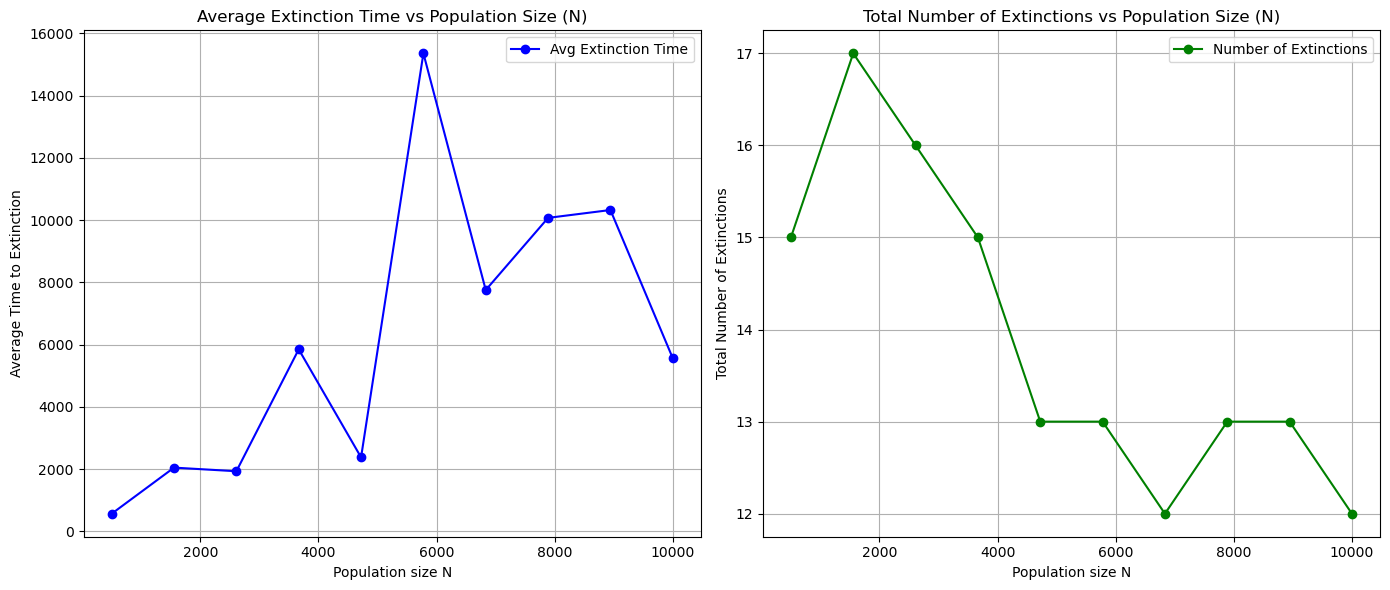

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
sims_ext = 30  # Number of simulations per N
beta_ext = np.logspace(-1, 1.5, sims_ext)  # Transmission rates in the range [0.1, 31.6]
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 200  # Simulation end time
N_diff = np.linspace(500, 10000, 10)  # Population sizes for which we will run simulations

# Initialize lists to store results
Ys_ext2 = []  # Average extinction times
extinction_counts = []  # Number of extinctions for each N

# Loop over different values of N (population sizes)
for n in N_diff:
    Ys_sim = []  # Temporary list to store extinction times for each simulation
    ext_count = 0  # Counter for the number of extinctions

    for sim in range(sims_ext):
        X0 = int(n) - 1  # Susceptible individuals (N-1)
        Y0 = 1  # Initial infected
        Z0 = 0  # Recovered

        # Run the simulation using gillespie_sir for the current N
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[sim], gamma_ext[sim], mu_ext[sim], X0 + Y0 + Z0, tend=t_end, seed=sim)

        # Find the index of the first 0 in the Ys (extinction time)
        if 0 in Ys:
            extinction_time = Ys.index(0)
            Ys_sim.append(extinction_time)  # Only append if extinction happens
            ext_count += 1  # Increment extinction count if extinction occurs
        else:
            # If no extinction occurs, do nothing
            pass

    # Calculate the average extinction time only if there were extinctions
    if Ys_sim:
        average_extinction_time = sum(Ys_sim) / len(Ys_sim)
        Ys_ext2.append(average_extinction_time)
    else:
        Ys_ext2.append(np.nan)  # If no extinctions, append NaN

    extinction_counts.append(ext_count)  # Store the number of extinctions for this N
    print(f'For N = {n}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}')

# Plot the average extinction time vs population size
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Average extinction time vs N
ax[0].plot(N_diff, Ys_ext2, marker='o', color='blue', label='Avg Extinction Time')
ax[0].set_title("Average Extinction Time vs Population Size (N)")
ax[0].set_xlabel("Population size N")
ax[0].set_ylabel("Average Time to Extinction")
ax[0].grid(True)
ax[0].legend()

# Plot 2: Number of extinctions vs N
ax[1].plot(N_diff, extinction_counts, marker='o', color='green', label='Number of Extinctions')
ax[1].set_title("Total Number of Extinctions vs Population Size (N)")
ax[1].set_xlabel("Population size N")
ax[1].set_ylabel("Total Number of Extinctions")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


For R0 = 5.00, average extinction time = 167.25
For R0 = 1.38, average extinction time = 1100.076923076923
For R0 = 1.04, average extinction time = 3352.65
For R0 = 0.98, average extinction time = 2167.85
For R0 = 1.01, average extinction time = 3852.55
For R0 = 1.11, average extinction time = 2451.6315789473683
For R0 = 1.26, average extinction time = 919.3571428571429
For R0 = 1.48, average extinction time = 572.0
For R0 = 1.76, average extinction time = 370.6363636363636
For R0 = 2.12, average extinction time = 376.8333333333333
For R0 = 2.59, average extinction time = 259.9
For R0 = 3.19, average extinction time = 219.83333333333334
For R0 = 3.97, average extinction time = 133.4
For R0 = 4.97, average extinction time = 81.66666666666667
For R0 = 6.26, average extinction time = 116.75
For R0 = 7.92, average extinction time = 81.4
For R0 = 10.06, average extinction time = 29.0
For R0 = 12.83, average extinction time = 36.333333333333336
For R0 = 16.42, average extinction time = 41.0


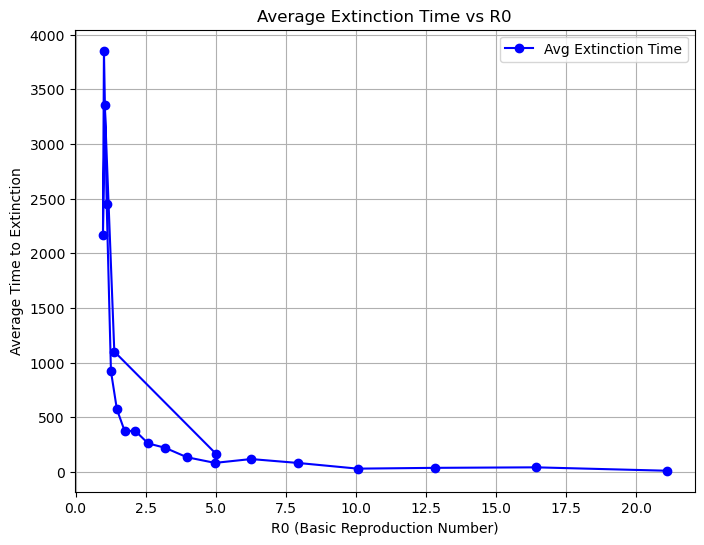

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
sims_ext = 20  # Increase the number of simulations to get more diverse R0 values

# Use logarithmic spacing for beta, gamma, and mu to generate more diverse values
beta_ext = np.logspace(-1, 1.5, sims_ext)  # Transmission rates in the range [0.1, 31.6]
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 200  # Simulation end time

X0 = 999  # Susceptible individuals (N-1)
Y0 = 1  # Initial infected
Z0 = 0  # Recovered

# Calculate R0 for each combination of beta, gamma, and mu
R0_ext = beta_ext / (gamma_ext + mu_ext)

Ys_ext2 = []  # List to store average extinction times for each R0

# Loop over different values of R0 by iterating over beta_ext, gamma_ext, and mu_ext
for i, R0 in enumerate(R0_ext):
    Ys_sim = []  # Temporary list to store extinction times for each simulation
    
    for sim in range(sims_ext):
        # Run the simulation using gillespie_sir for current beta, gamma, mu
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], X0 + Y0 + Z0, tend=t_end, seed=sim)

        # Find the index of the first 0 in the Ys (extinction time)
        try:
            extinction_time = Ys.index(0)
            Ys_sim.append(extinction_time)  # Only append if extinction happens
        except ValueError:
            # Do not append anything if extinction does not occur within the time limit
            pass

    # Calculate the average extinction time only if there were extinctions
    if Ys_sim:
        average_extinction_time = sum(Ys_sim) / len(Ys_sim)
        Ys_ext2.append(average_extinction_time)
    else:
        Ys_ext2.append(np.nan)  # If no extinctions, append NaN or omit

    print(f'For R0 = {R0:.2f}, average extinction time = {Ys_ext2[-1]}')

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(R0_ext, Ys_ext2, marker='o', color='blue', label='Avg Extinction Time')
ax.set_title("Average Extinction Time vs R0")
ax.set_xlabel("R0 (Basic Reproduction Number)")
ax.set_ylabel("Average Time to Extinction")
ax.grid(True)
ax.legend()

plt.show()


For N = 500.0, total extinctions = 6, average extinction time = 120.83333333333333
For N = 827.5862068965517, total extinctions = 17, average extinction time = 513.9411764705883
For N = 1155.1724137931035, total extinctions = 23, average extinction time = 2240.304347826087
For N = 1482.7586206896553, total extinctions = 29, average extinction time = 2939.9655172413795
For N = 1810.344827586207, total extinctions = 29, average extinction time = 1710.0689655172414
For N = 2137.9310344827586, total extinctions = 30, average extinction time = 6099.0
For N = 2465.5172413793107, total extinctions = 28, average extinction time = 2930.214285714286
For N = 2793.1034482758623, total extinctions = 28, average extinction time = 3375.3928571428573
For N = 3120.689655172414, total extinctions = 27, average extinction time = 5484.962962962963
For N = 3448.2758620689656, total extinctions = 22, average extinction time = 2860.5454545454545
For N = 3775.862068965517, total extinctions = 22, average exti

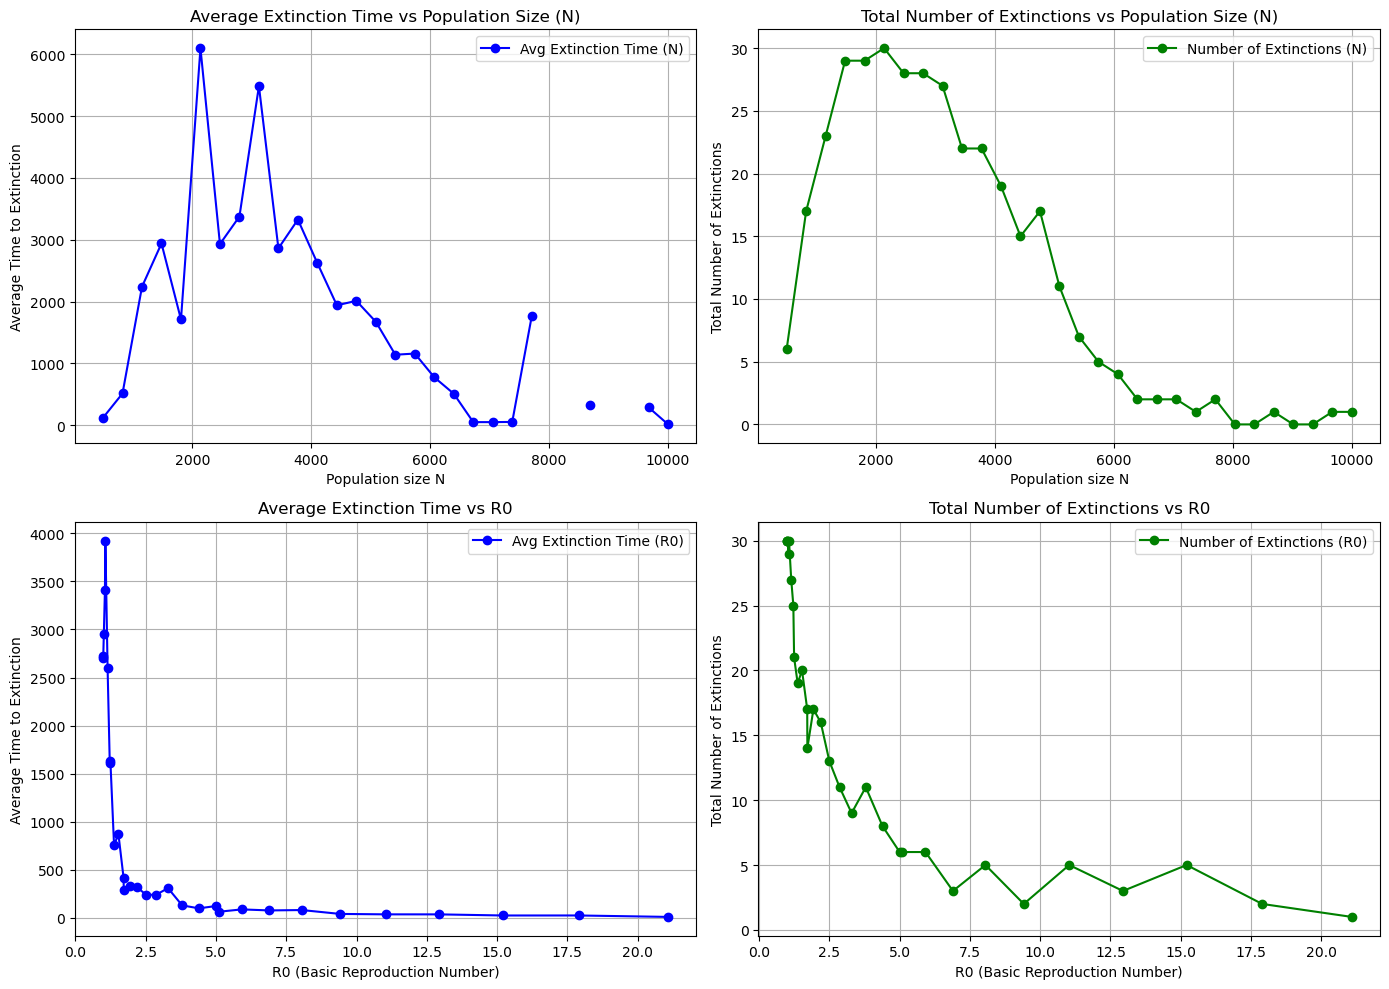

In [143]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation_and_plot(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    - param_diff: Array of different values of N or R0.
    - param_name: Name of the parameter being varied ("N" or "R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions
        
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)
            else:
                X0 = X0  # Keep it fixed for R0

            # Run the simulation using gillespie_sir for current beta, gamma, mu
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs
            else:
                # If no extinction occurs, do nothing
                pass

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted


# Example parameters
sims_ext = 30  # Number of simulations per parameter
beta_ext = np.logspace(-1, 1.5, sims_ext)  # Transmission rates in the range [0.1, 31.6]
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 200  # Simulation end time

# N and R0 values
N_diff = np.linspace(500, 10000, sims_ext)  # Population sizes for which we will run simulations
R0_diff = beta_ext / (gamma_ext + mu_ext)  # Calculate R0 values
X0 = 999  # Initial number of susceptible individuals
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

# Run the simulations for N and R0
N_sorted, Ys_ext2_N_sorted, extinction_counts_N_sorted = run_simulation_and_plot(N_diff, "N", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)
R0_sorted, Ys_ext2_R0_sorted, extinction_counts_R0_sorted = run_simulation_and_plot(R0_diff, "R0", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)

# Create 2x2 subplot for all four plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Average extinction time vs N
ax[0, 0].plot(N_sorted, Ys_ext2_N_sorted, marker='o', color='blue', label='Avg Extinction Time (N)')
ax[0, 0].set_title("Average Extinction Time vs Population Size (N)")
ax[0, 0].set_xlabel("Population size N")
ax[0, 0].set_ylabel("Average Time to Extinction")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs N
ax[0, 1].plot(N_sorted, extinction_counts_N_sorted, marker='o', color='green', label='Number of Extinctions (N)')
ax[0, 1].set_title("Total Number of Extinctions vs Population Size (N)")
ax[0, 1].set_xlabel("Population size N")
ax[0, 1].set_ylabel("Total Number of Extinctions")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 3: Average extinction time vs R0
ax[1, 0].plot(R0_sorted, Ys_ext2_R0_sorted, marker='o', color='blue', label='Avg Extinction Time (R0)')
ax[1, 0].set_title("Average Extinction Time vs R0")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Average Time to Extinction")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 4: Total number of extinctions vs R0
ax[1, 1].plot(R0_sorted, extinction_counts_R0_sorted, marker='o', color='green', label='Number of Extinctions (R0)')
ax[1, 1].set_title("Total Number of Extinctions vs R0")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.tight_layout()
plt.show()
